In [1]:
import json
import numpy as np
import cs_vqe_classes.cs_vqe_circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
import utils.linalg_tools as la
from utils.molecule_tools import get_molecule
from utils.cs_vqe_tools import greedy_dfs
from matplotlib import pyplot as plt
from qat.interop.qiskit import qiskit_to_qlm
from qiskit.aqua.components.optimizers import IMFIL

/home/ucaptwe/anaconda3/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/home/ucaptwe/anaconda3/lib/python3.8/site-packages/qiskit/aqua/components/optimizers/optimizer.py:49: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.components.optimizers',


In [2]:
with open('data/model_data.json', 'r') as json_file:
    model_data = json.load(json_file)
    
model_data.keys()

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'H3+_STO-3G_SINGLET_alt', 'HeH+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET_alt', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'H2O_STO-3G_SINGLET_alt', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'N+_STO-3G_SINGLET', 'OH+_STO-3G_SINGLET', 'CH2_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_SINGLET', 'NH_STO-3G_SINGLET', 'F+_STO-3G_SINGLET', 'Li+_STO-3G_SINGLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET'])

In [3]:
speciesname = "B+_STO-3G_SINGLET"
molecule    = model_data[speciesname]

ham         = molecule['ham']
uccsd       = molecule['uccsd']
hf_config   = molecule['hf_config']
num_qubits  = molecule['num_qubits']
terms_noncon= molecule['terms_noncon']
num_tapered = molecule['num_tapered']
print(num_tapered+num_qubits, num_qubits)

10 5


B+_STO-3G_SINGLET reaches chemical accuracy for 3-qubit CS-VQE


/home/ucaptwe/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1266: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


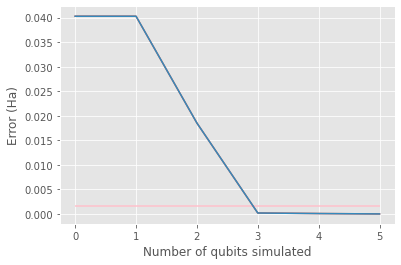

In [4]:
mol_circ = cs_circ.cs_vqe_circuit(hamiltonian = ham,
                                  terms_noncon= terms_noncon,
                                  num_qubits  = num_qubits,
                                  hf_config   = hf_config)

num_sim_q = mol_circ.chem_acc_num_q
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))
mol_circ.plot_cs_vqe_errors()

In [5]:
#anz_ops = mol_circ.sufficient_anz_terms(uccsd)

In [6]:
anz_ops = ['XIZXX', 'IYZXX'] #for B+ 
#anz_ops = ['YXIIXXII', 'IXIIZZZY', 'XYIIZZXX', 'YYIIXYII'] #for HF

#anz=uccsd
anz = {op:uccsd[op] for op in anz_ops}
anz_red = mol_circ.project_anz_terms_alt(anz_terms=anz, num_sim_q = num_sim_q)
ham_red = mol_circ.ham_reduced[num_sim_q]
qc = mol_circ.build_circuit(anz, num_sim_q)
init_params = mol_circ.init_param

print('Number of circuit parameters:', qc.num_parameters, '\n')


Number of circuit parameters: 4 



/home/ucaptwe/anaconda3/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


# Performing the simulation *without* noise

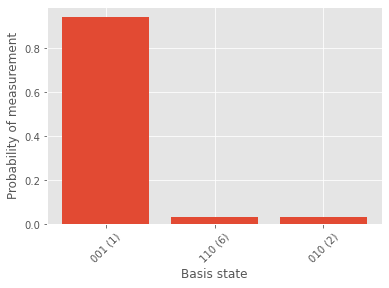

*   Performing 3-qubit CS-VQE over qubit positions 3, 2, 1 ...


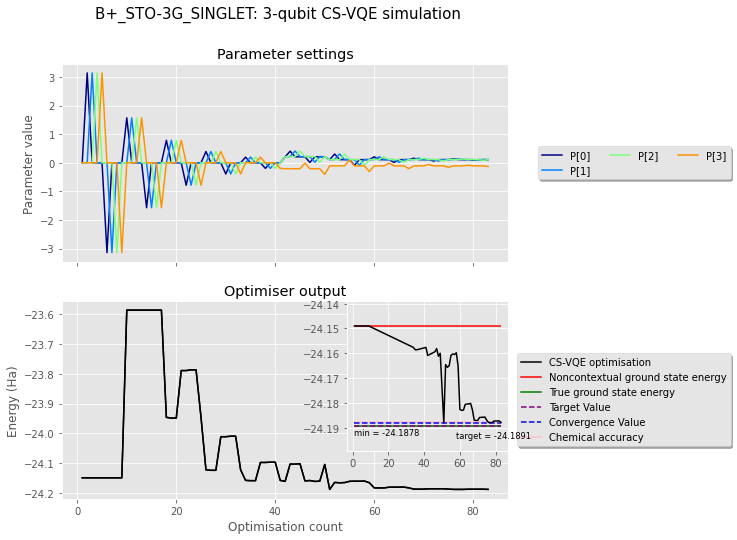

In [7]:
cs_vqe_results = mol_circ.CS_VQE(anz_terms=anz, 
                                 num_sim_q=num_sim_q, 
                                 optimizer=IMFIL(maxiter=150), 
                                 param_bound=np.pi,
                                 noise=False,
                                show_amps=True)

title = '%s: %i-qubit CS-VQE simulation' % (speciesname, num_sim_q)
fig = plot.plot_parameter_settings(cs_vqe_results, title=title)

In [8]:
qc_qlm = qiskit_to_qlm(qc)

In [45]:
qc_qlm.get_variables()

{'P[0]', 'P[1]', 'P[2]', 'P[3]'}

In [48]:
qc_qlm_dict = {'num_qubits':qc_qlm.nbqbits,
               'params':list(qc_qlm.get_variables()),
               'instructions':list(qc_qlm.iterate_simple()),
               'gate_defs':list(qc_qlm.gateDic)}

In [47]:
import json 
 
with open("data/QLM_circuits/test.json", "w") as outfile: 
    json.dump(qc_qlm_dict, outfile)

TypeError: Object of type ArithExpression is not JSON serializable